In [1]:
import requests

import datetime
import os
import json
from collections import Counter

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

In [2]:
API_KEY = os.environ["TMDB_API_KEY"]

In [3]:
url = "https://api.themoviedb.org/3/movie/76341?api_key=" + API_KEY

In [4]:
response = requests.get(url)

In [5]:
#response.json()

## Get daily list of TV shows for today

This uses TMDB's daily list call as per [docs](https://developers.themoviedb.org/3/getting-started/daily-file-exports). Just CURL this in the terminal and extract file.

In [6]:
# build the download URL using today's date

today_datetime = datetime.datetime.today()

daily_list_url = "http://files.tmdb.org/p/exports/tv_series_ids_{month:02d}_{day:02d}_{year}.json.gz".format(day=today_datetime.day, 
                                                                                                     month=today_datetime.month, 
                                                                                                     year=today_datetime.year)

daily_list_url

'http://files.tmdb.org/p/exports/tv_series_ids_05_17_2021.json.gz'

## Read file, build a single dict

The file provided is a JSONL. In the dict, key will be the API id of the show. Note that this data contains the "popularity" which is a measure of how much the show is viewed and voted on TMDB (see the docs above) - we will use it to remove the unpopular shows for the sake of speed/data reduction.

In [15]:
!head -n 5 shows_list.json

{"id":1,"original_name":"プライド","popularity":2.765}
{"id":2,"original_name":"Clerks: The Animated Series","popularity":13.218}
{"id":3,"original_name":"The Message","popularity":1.244}
{"id":4,"original_name":"The Amazing Mrs Pritchard","popularity":2.237}
{"id":5,"original_name":"La Job","popularity":7.626}


In [7]:
f = open('shows_list.json')

d_shows_ids = {}
for line in f.readlines():
    d = json.loads(line)    
    d_shows_ids[d['id']] = {'original_name': d['original_name'], 'popularity': d['popularity']}

In [8]:
# sanity checks
len(d_shows_ids)

for k in d_shows_ids:
    if d_shows_ids[k]['original_name'] == "The Handmaid's Tale":
        print(k, d_shows_ids[k])
        break
        
k
api_url = "https://api.themoviedb.org/3/tv/{show_id}/content_ratings?api_key={api_key}".format(show_id=k, 
                                                                                               api_key=API_KEY)
r = requests.get(api_url)
r.json()

109348

69478 {'original_name': "The Handmaid's Tale", 'popularity': 927.708}


69478

{'results': [{'iso_3166_1': 'DE', 'rating': '16'},
  {'iso_3166_1': 'US', 'rating': 'TV-MA'},
  {'iso_3166_1': 'GB', 'rating': '15'},
  {'iso_3166_1': 'BR', 'rating': '16'},
  {'iso_3166_1': 'PT', 'rating': '16'},
  {'iso_3166_1': 'SE', 'rating': '15'},
  {'iso_3166_1': 'ES', 'rating': '18'}],
 'id': 69478}

## Look at the popularities

The data file dump only has popularities, can use those to filter - because there's too many

In [9]:
popularities = [d_shows_ids[k]['popularity'] for k in d_shows_ids.keys()]

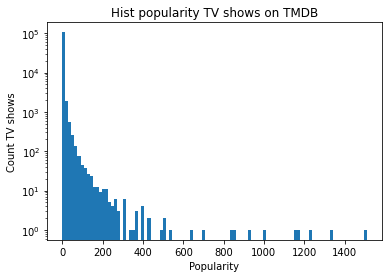

In [10]:
plt.hist(popularities, log=True, bins=100)

plt.title('Hist popularity TV shows on TMDB')
plt.xlabel('Popularity')
plt.ylabel('Count TV shows')
plt.show();

In [11]:
np.mean(popularities), np.median(popularities), np.std(popularities), np.max(popularities)

len([pop for pop in popularities if pop > 3])

(2.7540289168526173, 0.6, 14.839995151442606, 1509.296)

15805

## Attach content ratings to shows dict

edit as you please to do just some - this is obvs slow due to API limits/performance.


Using just the most popular ones as per the above - using a threshold of 3 (~16000 TV shows as of the dat of the last run of this).

In [120]:
%%time

# this is to select just a subset based on the popularity
l_shows_ids_selected = [k for k in d_shows_ids if d_shows_ids[k]['popularity'] >= 0.8 and d_shows_ids[k]['popularity'] < 1]

print(len(l_shows_ids_selected))

i = 0     # to keep track of where we are
for k in l_shows_ids_selected:

    api_url = "https://api.themoviedb.org/3/tv/{show_id}/content_ratings?api_key={api_key}".format(show_id=k, 
                                                                                               api_key=API_KEY)
    res = requests.get(api_url).json()
    d_shows_ids[k]['content_ratings'] = res['results']

    i += 1
    
    if i % 100 == 0:
        print(i)

6720
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
CPU times: user 2min 13s, sys: 10.5 s, total: 2min 23s
Wall time: 20min 39s


In [89]:
json.dump(d_shows_ids, open('d_popular_shows_data.json', 'w'))

In [83]:
d_shows_ids[300]

{'original_name': 'Terminal City', 'popularity': 2.648, 'content_ratings': []}

## Look at ratings per country

In [85]:
# isolate the data with ratings only - rest is useless for this

d_data = {
    k: d_shows_ids[k] for k in d_shows_ids if 'content_ratings' in d_shows_ids[k] and d_shows_ids[k]['content_ratings'] != [] 
}

len(d_data)

10180

## Look at ratings per country

* For the US ones, see [here](https://en.wikipedia.org/wiki/TV_Parental_Guidelines)
* For GB ones, see [here](https://www.bbfc.co.uk/about-classification)

### Correspondence US-UK (I did this mapping)

* TV-Y (very young audience)
* TV-Y7 (7+)                                                --> 12/12A (for 12+)
* TV-G (all ages)                                           --> U 
* TV-PG (parental guidance, unsuitable for young children)  --> PG
* TV-14 (14+)                                               --> 15
* TV-MA (mature audience, adult only)                       --> 18

The UK has R18 too which is adult only and only for special licences (e.g. sexy shops).



In [86]:
# take countries of interest - say US and GB

names, us_ratings, uk_ratings = [], [], []
for k in d_data:
    ratings = d_data[k]['content_ratings']
    countries = [item['iso_3166_1'] for item in ratings]
    if 'US' in countries and 'GB' in countries:
        names.append(d_data[k]['original_name'])
        for rating in ratings:
            if rating['iso_3166_1'] == 'US':
                us_ratings.append(rating['rating'])
            elif rating['iso_3166_1'] == 'GB':
                uk_ratings.append(rating['rating'])

In [ ]:
# use the US-UK mapping above

us_ratings_mapped = 

In [87]:
len(names), len(us_ratings), len(uk_ratings)

(726, 726, 726)

In [88]:
# check a name
ix = names.index("Snowpiercer")

names[ix], us_ratings[ix], uk_ratings[ix]

('Snowpiercer', 'TV-MA', '18')

In [92]:
# look at the distrib of US ratings, and others

c = Counter(us_ratings)
c.most_common()


c = Counter(uk_ratings)
c.most_common()

[('TV-14', 279),
 ('TV-MA', 277),
 ('TV-PG', 106),
 ('TV-Y7', 26),
 ('TV-G', 16),
 ('NR', 12),
 ('TV-Y', 10)]

[('15', 374),
 ('12', 126),
 ('18', 117),
 ('PG', 60),
 ('U', 41),
 ('12A', 5),
 ('R18', 3)]

In [115]:
r18s = [i for i in range(len(uk_ratings)) if uk_ratings[i] =='R18']

for ix in r18s:
    names[ix], us_ratings[ix]

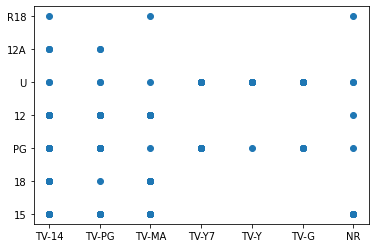

In [93]:
plt.scatter(us_ratings, uk_ratings)

plt.show();

In [114]:
us_chosen_rating_ixs = [i for i in range(len(uk_ratings)) if us_ratings[i] =='TV-Y']
c= Counter([uk_ratings[ix] for ix in us_chosen_rating_ixs ])

c.most_common()

[('U', 9), ('PG', 1)]

In [118]:
# look for names
for i in range(len(names)):
    if us_ratings[i] == 'TV-14' and uk_ratings[i] in ('18', 'R18'):
        print(names[i], uk_ratings[i])

House 18
CSI: Crime Scene Investigation 18
Battlestar Galactica 18
Millennium 18
ER 18
The Inbetweeners 18
輪るピングドラム 18
化物語 18
In the Flesh 18
Bates Motel 18
俺の妹がこんなに可愛いわけがない 18
From Dusk Till Dawn: The Series 18
The Magicians 18
Marvel's Runaways 18
レールウォーズ R18
Dispatches from Elsewhere 18
Evil 18
荒ぶる季節の乙女どもよ。 18
FBI: Most Wanted 18
McMillion$ 18
